In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import visionloader as vl
from sklearn.cluster import SpectralClustering
import os
import src.fitting as fitting
import src.multielec_utils as mutils
import src.old_labview_data_reader as oldlv
from mpl_toolkits.mplot3d import Axes3D
import cvxpy as cp
from scipy.optimize import minimize
import statsmodels.api as sm
import operator as op
import itertools as it

%load_ext autoreload
%autoreload 2
%matplotlib ipympl

In [2]:
# Current values in uA

Ivals = np.array([0.10053543, 0.11310236, 0.11938583, 0.13195276, 0.14451969,                        
                       0.16337008, 0.17593701, 0.1947874 , 0.2136378 , 0.23877165,
                       0.25762205, 0.2780315 , 0.30330709, 0.35385827, 0.37913386,
                       0.42968504, 0.45496063, 0.50551181, 0.55606299, 0.60661417,
                       0.68244094, 0.73299213, 0.8088189 , 0.88464567, 0.98574803,
                       1.10433071, 1.20472441, 1.30511811, 1.40551181, 1.60629921,
                       1.70669291, 1.90748031, 2.10826772, 2.30905512, 2.50984252,
                       2.81102362, 3.11220472, 3.41338583, 3.71456693, 4.1161])

In [3]:
ANALYSIS_BASE = "/Volumes/Analysis"
MATFILE_BASE = "/Volumes/Scratch/Users/praful/triplet_gsort_matfiles_20220420"
gsort_path = "/Volumes/Scratch/Users/praful/newlv_gsort_v2_30um_periphery"
gsort_path_1elec = "/Volumes/Scratch/Users/praful/single_gsort_v2_30um_periphery-affinity_cosine"

In [4]:
dataset = "2020-10-18-5"
estim = "data006/data006-all_v2"
estim_1elec = "data001"
electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim)

In [5]:
wnoise = "kilosort_data002/data002"
vis_datapath = os.path.join(ANALYSIS_BASE, dataset, wnoise)
vis_datarun = wnoise.split('/')[-1]
vcd = vl.load_vision_data(
    vis_datapath,
    vis_datarun,
    include_neurons=True,
    include_ei=True,
    include_params=True,
    include_noise=True,
)

coords = vcd.get_electrode_map()

In [6]:
p = 2
all_cells = np.array([197, 212, 220], dtype=int)

In [7]:
def all_combos(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    powerset = list(it.chain.from_iterable(it.combinations(s, r) for r in range(1, len(s)+1)))
    
    targets = []
    nontargets = []
    for i in powerset:
        for j in powerset:
            if len(np.intersect1d(np.array(i), np.array(j))) == 0:
                targets.append(np.array(i))
                nontargets.append(np.array(j))
                
    return np.array(targets, dtype=object), np.array(nontargets, dtype=object)

In [8]:
def binaryClustering(X, y, T, nll_thr=0.9, min_points_per_cluster=30, child='', verbose=False):
    if verbose:
        print(child)
        print(len(X))
    X_bin_init, y_bin_init = fitting.convertToBinaryClassifier(y, T, X)
    results_init = minimize(fitting.negLL, x0=np.array([-1, 1, 1, 1]), args=(X_bin_init, y_bin_init, False, 'none'))
#     nll_MLE_init = fitting.negLL(results_init.x, X_bin_init, y_bin_init, False, 'none')
    nll_MLE_init = results_init.fun
    if verbose:
        print(nll_MLE_init)

    if len(X) >= min_points_per_cluster and nll_MLE_init < nll_thr and results_init.x[0] < 0:
        return [(X, y, results_init.x)]
    elif len(X) < min_points_per_cluster:
        return [(X, y, [np.nan])]
    else:
        clustering = SpectralClustering(n_clusters=2, 
                                        assign_labels='discretize',
                                        affinity='nearest_neighbors').fit(X)

        cluster0 = np.where(clustering.labels_ == 0)[0]
        cluster1 = np.where(clustering.labels_ == 1)[0]

   
        return binaryClustering(X[cluster0], y[cluster0], T[cluster0], nll_thr=nll_thr, min_points_per_cluster=min_points_per_cluster, child='left', verbose=verbose) + binaryClustering(X[cluster1], y[cluster1], T[cluster1], nll_thr=nll_thr, min_points_per_cluster=min_points_per_cluster, child='right', verbose=verbose) 

In [9]:
def classifySelectivity(targets, nontargets):
    target_types = np.zeros(len(targets), dtype=bool)
    for i in range(len(targets)):
        t = targets[i]
        cell_type = vcd.get_cell_type_for_cell(t).lower()
        if 'on' in cell_type:
            target_types[i] = True

    nt_types = np.zeros(len(nontargets), dtype=bool)
    for i in range(len(nontargets)):
        nt = nontargets[i]
        cell_type = vcd.get_cell_type_for_cell(nt).lower()
        if 'on' in cell_type:
            nt_types[i] = True

    if (np.all(target_types) and ~np.any(nt_types)) or (~np.any(target_types) and np.all(nt_types)):
        classification = 'ON/OFF'

    elif np.all(target_types) and np.all(nt_types):
        classification = 'ON/ON'

    elif ~np.any(target_types) and ~np.any(nt_types):
        classification = 'OFF/OFF'

    else:
        classification = 'mixed'
        
    return classification

In [10]:
def get1elecSelectivity(dataset, multipath, gsort_path_1elec, estim_1elec, wnoise, p, targets, nontargets, show_plots=False):
    multi_elecs = mutils.get_stim_elecs_newlv(multipath, p)
    curr_cells = np.sort(np.concatenate((targets, nontargets)))
    
    all_signals = []
    target_sigmoids = []
    nt_sigmoids = []
    
    for elec in multi_elecs:
        filepath_1elec = os.path.join(gsort_path_1elec, dataset, estim_1elec, wnoise, "p" + str(elec))
        if show_plots:
            plt.figure()
            plt.title(str(elec))
            plt.ylim(-0.1, 1.1)
            plt.ylabel('Activation Probability')
            plt.xlabel('Current Amplitude (uA)')

        target_sigmoids_elec = []
        nt_sigmoids_elec = []

        cell_signals = []
        for cell in curr_cells:
            k = 0
            probs = []
            trials = []
            signals = []
            while True:
                try:
                    with open(os.path.join(filepath_1elec, "gsort_single_v2_n" + str(cell) + "_p" + str(elec) + "_k" + str(k) + ".pkl"), "rb") as f:
                        prob_dict = pickle.load(f)
                        probs.append(prob_dict["cosine_prob"][0])
                        trials.append(prob_dict["num_trials"])
                        electrode_list = prob_dict["electrode_list"]

                    signal = oldlv.get_oldlabview_pp_data(os.path.join(ANALYSIS_BASE, dataset, estim_1elec), 
                                                          elec, k)[:,electrode_list,:55]
                    signals.append(signal)
                except:
                    break

                k += 1

            cell_signals.append(signals)
            trials = np.array(trials, dtype=int)
            probs = np.array(probs)

            if len(probs) > 0:    
                probs = fitting.disambiguate_sigmoid(probs, spont_limit = 0.15, noise_limit = 0.1)

                X_bin, y_bin = fitting.convertToBinaryClassifier(probs, trials, Ivals[:k].reshape(-1, 1))

                results = minimize(fitting.negLL, x0=np.array([-1, 1]), args=(X_bin, y_bin, False, 'none'))

                currs = np.linspace(0.1, 4.5, 100)
                sigmoid = fitting.fsigmoid(sm.add_constant(currs.reshape(-1, 1)), results.x)
                if cell in targets:
                    target_sigmoids_elec.append(sigmoid)
                else:
                    nt_sigmoids_elec.append(sigmoid)

                if show_plots:
                    plt.plot(currs, sigmoid)
                    plt.scatter(Ivals[:k], probs, alpha=0.5, 
                                label=vcd.get_cell_type_for_cell(cell) + ' ' + str(cell))

        if show_plots:
            plt.legend()
            plt.show()

        all_signals.append(cell_signals)
        target_sigmoids.append(np.array(target_sigmoids_elec))
        nt_sigmoids.append(np.array(nt_sigmoids_elec))
    
    selec_vals_1elec = np.zeros(len(multi_elecs))
    for i in range(len(multi_elecs)):
        selec_vals_1elec[i] = np.amax(np.multiply.reduce(target_sigmoids[i], axis=0) * 
                                      (1 - np.amax(nt_sigmoids[i], axis=0)))
        
    best_1elec = np.amax(selec_vals_1elec)
    
    return best_1elec

In [11]:
def fitMultielecSurface(multipath, gsort_multipath, dataset, estim, wnoise, p,
                        cells, downsample=False, downsample_trials=10, downsample_factor=2,
                        load_from_mat=True, nll_thr=0.9, min_points_per_cluster=15,
                        show_plots=False, verbose=False):
    weights = []
    amps = []
    probs = []
    
    for cell in cells:
        X, y, T = mutils.loadNewLVData(multipath, gsort_multipath, dataset, estim, wnoise, p, cell,
                                       downsample=downsample, downsample_trials=downsample_trials, 
                                       downsample_factor=downsample_factor,load_from_mat=load_from_mat, 
                                       MATFILE_BASE=MATFILE_BASE)
        amps.append(X)
        probs.append(y)
        output = binaryClustering(X, y, T, nll_thr=nll_thr, min_points_per_cluster=min_points_per_cluster, verbose=verbose)
        
        cell_weights = []
        for i in range(len(output)):
            if verbose:
                print(output[i][2])

            if len(output[i][2]) > 1:
    #             OLS_X = sm.add_constant(output[i][0], has_constant='add')
    #             OLS_y = np.log(output[i][1] / (1 - output[i][1]))

    #             OLS_w = (np.linalg.inv(OLS_X.T @ OLS_X) @ OLS_X.T) @ OLS_y
    #             print(OLS_w)

                cell_weights.append(output[i][2])

                if show_plots:
                    normal = output[i][2][1:]

                    d = output[i][2][0]
                    xmin = np.amin(output[i][0][:, 0])
                    xmax = np.amax(output[i][0][:, 0])
                    ymin = np.amin(output[i][0][:, 1])
                    ymax = np.amax(output[i][0][:, 1])

                    # create x,y
                    xx, yy = np.meshgrid(np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100))

                    # calculate corresponding z
                    z = (-d - normal[0] * xx - normal[1] * yy) / normal[2]
                    z[z > 1.8] = np.nan
                    z[z < -1.8] = np.nan

                    # plot the surface
                    fig = plt.figure()
                    fig.clear()
                    ax = Axes3D(fig)
                    ax.plot_surface(xx, yy, z, alpha=0.5)
                    plt.xlabel(r'$I_1$')
                    plt.ylabel(r'$I_2$')
                    plt.xlim(-1.8, 1.8)
                    plt.ylim(-1.8, 1.8)
                    ax.set_zlim(-1.8, 1.8)
                    ax.set_zlabel(r'$I_3$')

                    scat = ax.scatter(output[i][0][:, 0], 
                                output[i][0][:, 1],
                                output[i][0][:, 2], marker='o', s=20, c=output[i][1], alpha=0.8)

                    clb = plt.colorbar(scat)
                    plt.show()

        weights.append(np.array(cell_weights))
        
    return weights, amps, probs

In [12]:
def cartesian_product_pp(arrays, out=None):
    la = len(arrays)
    h, w = zip(*map(op.attrgetter('shape'), arrays))
    w = np.fromiter(it.chain([0], w), int, la+ 1)
    W = w.cumsum()
    h = *h, W[la]
    dtype = np.result_type(*arrays)
    arr = np.empty(h, dtype=dtype)
    arrs = *it.accumulate(it.chain((arr,), it.repeat(0, la-1)), np.ndarray.__getitem__),
    idx = slice(None), *it.repeat(None, la-1)
    for i in range(la-1, 0, -1):
        arrs[i][..., W[i]:W[i+1]] = arrays[i][idx[:la-i]]
        arrs[i-1][1:] = arrs[i]
    arr[..., W[0]:W[1]] = arrays[0][idx]
    return arr.reshape(-1, W[la])

In [13]:
def compute_pt(T):
    return 1/(np.exp(T)+1)

def compute_pn(T):
    return np.exp(T)/(np.exp(T)+1)

In [14]:
def computeSelecVec(target_combos, nt_weights, I_max=1.78125, verbose=False):
    selec_vals = np.zeros(len(target_combos))
    x_vals = np.zeros((len(target_combos), 3))
    for i in range(len(target_combos)):
        if verbose:
            print(i)
        T_t = cp.Variable(1)
        T_n = cp.Variable(1)
        x = cp.Variable(3)

        constraints = [
            -target_combos[i, :, 0] - target_combos[i, :, 1:] @ x  <= T_t,
            nt_weights[:, 0] + nt_weights[:, 1:] @ x <= T_n,
            x[0] <= 1.4,
            -I_max <= x[0],
            x[1] <= I_max,
            -I_max <= x[1], 
            x[2] <= I_max,
            -I_max <= x[2],  
        ]

        objective_function = cp.exp(T_n) + cp.exp(T_t)

        objective = cp.Minimize(objective_function)
        prob = cp.Problem(objective, constraints)
        opt_val  = prob.solve()

        if verbose:
            print(f"Optimal value {opt_val}")

            print(f"optimal p_t {compute_pt(T_t.value)[0]}")
            print(f"optimal p_n {compute_pn(T_n.value)[0]}")
            print(f"optimal T_t {T_t.value[0]}")
            print(f"optimal T_n {T_n.value[0]}")
            print(x.value)

        selec_vals[i] = compute_pt(T_t.value)[0] * (1 - compute_pn(T_n.value)[0])
        x_vals[i] = x.value
        
    return selec_vals, x_vals

In [15]:
all_targets, all_nontargets = all_combos(all_cells)

[197] [212] ON/ON


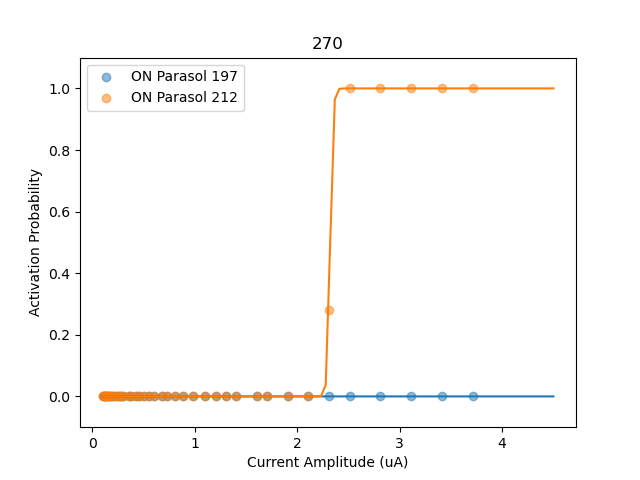

/tmp/ipykernel_12311/3251759083.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


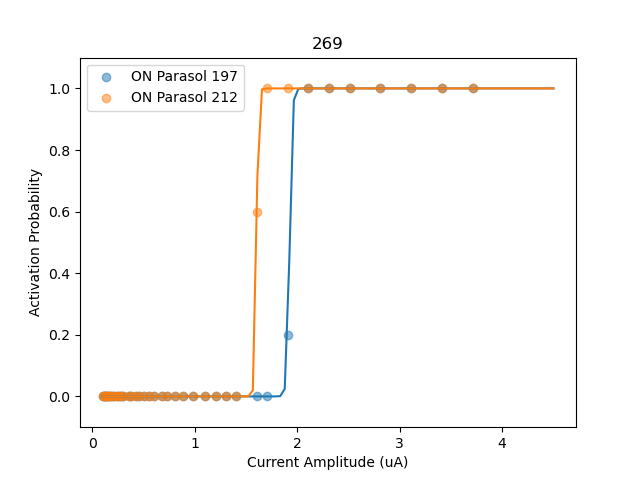

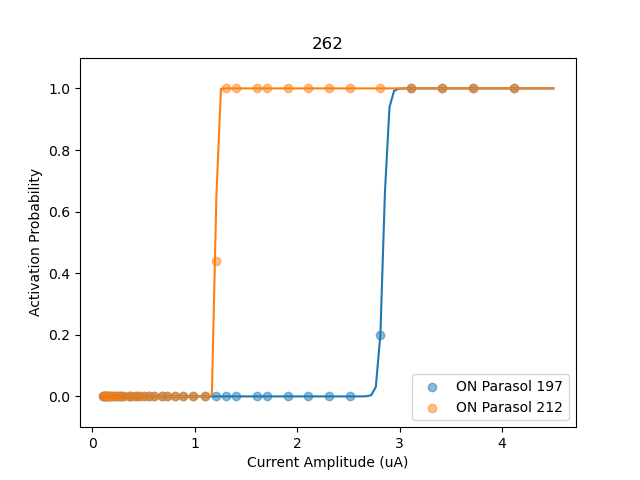

2.4362565442565486e-05

1048
0.9960446407232423
left
643
0.9603139682636246
left
310
0.9321094808603236
left
181
0.928248733790311
left
84
0.8135537617787224
right
97
0.8857153958073593
right
129
0.803715921308038
right
333
0.9127189600560696
left
183
0.8564472052230795
right
150
0.9546487203182725
left
59
0.9081991039855555
left
27
0.8706457506774945
right
32
0.9001134941768338
left
19
0.9033495607012234
left
8
0.9532427550183866
right
11
0.8629445583782519
right
13
0.864394375215054
right
91
0.8411397547011886
right
405
0.9489642041244308
left
281
0.8732653786849811
right
124
0.9335401622872812
left
63
0.8633143466536931
right
61
0.8471092943869865
[-19.64510847  -2.99763762  -9.29591375  -9.65391845]


/tmp/ipykernel_12311/3784309780.py:52: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


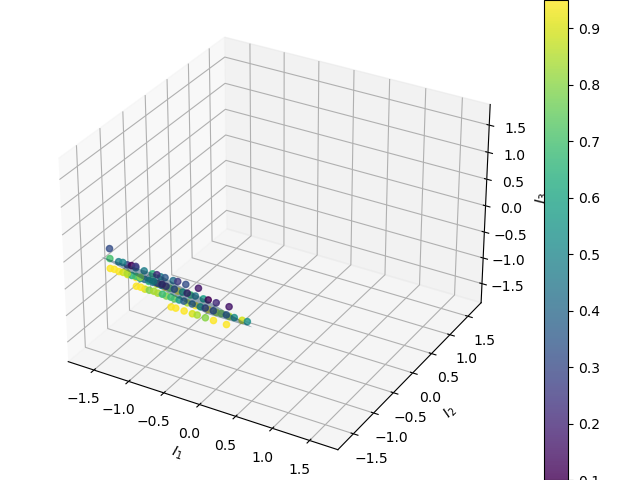

[-15.5306874   -1.44294325  -0.65987288  -8.09934576]


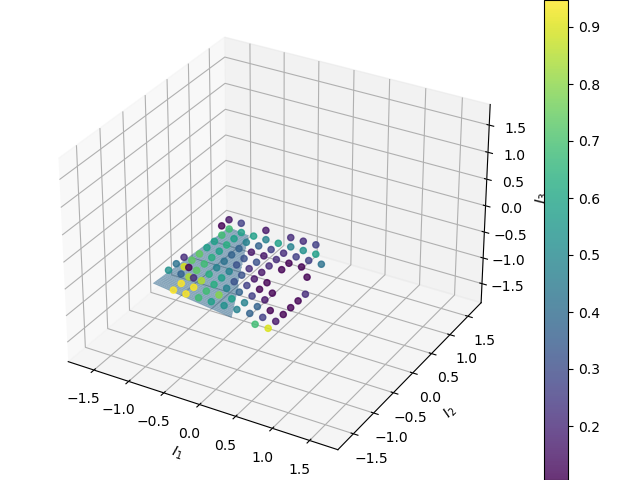

[-18.43129132  -2.87682748  -8.53808052  -8.91423306]


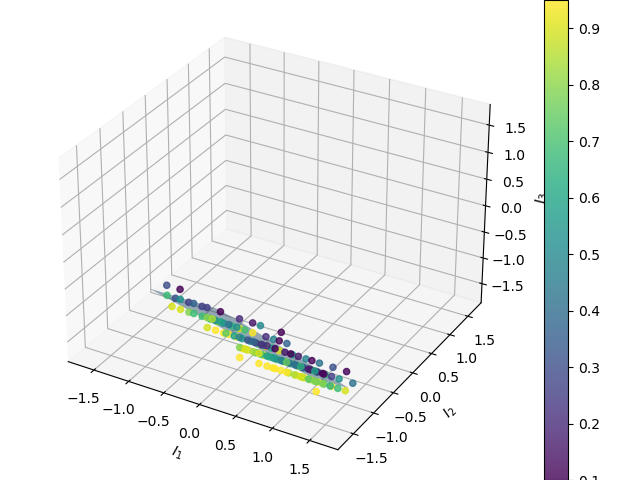

[-12.77800724  -1.29578162  -8.03934539  -0.74606107]


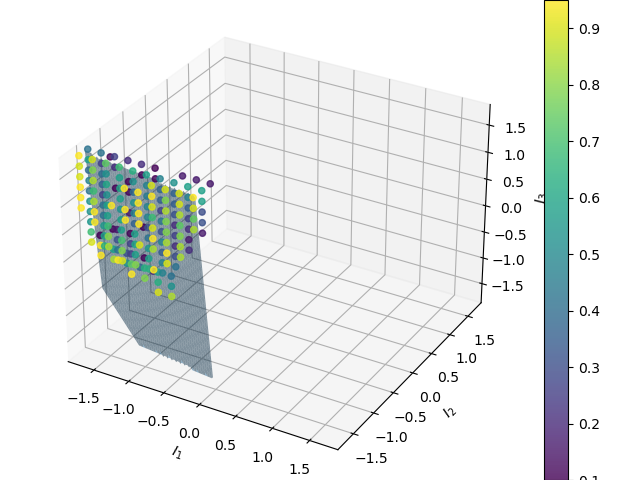

[-15.42943124   0.47912683  -5.04029632   3.67926722]


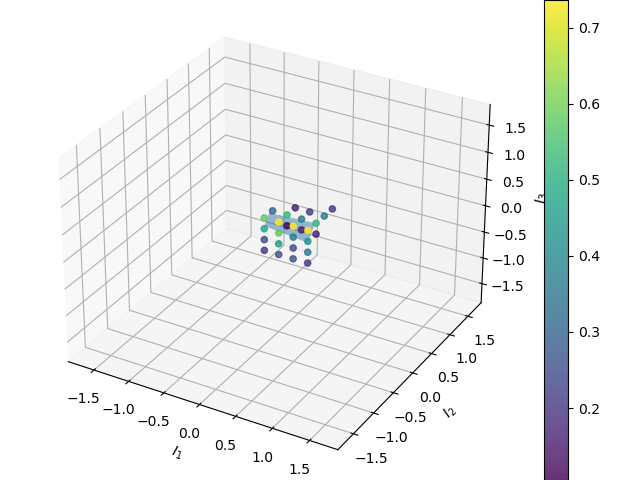

[nan]
[nan]
[nan]
[-19.51189943  -2.73019206 -12.22660654  -3.38933404]


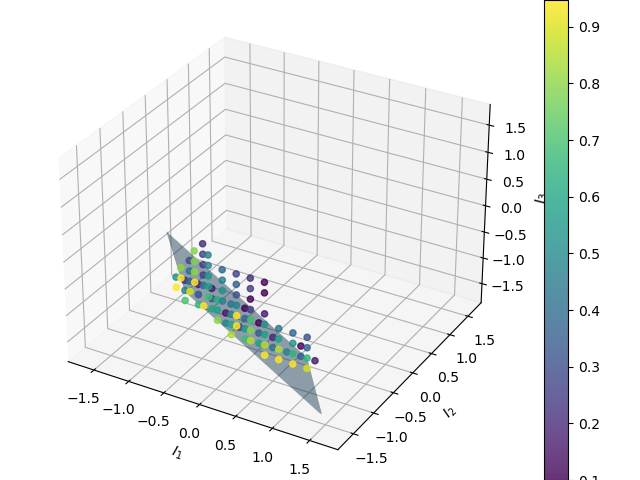

[-11.36903469   2.38524017   5.40514346   4.6208611 ]


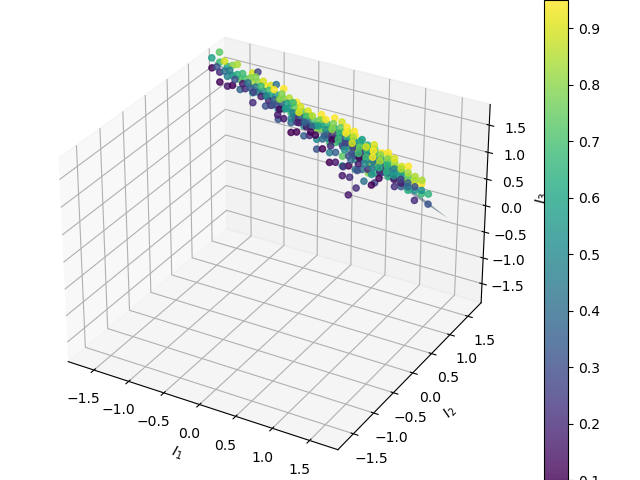

[-16.86886866   1.17176924   6.74518354  -2.65308146]


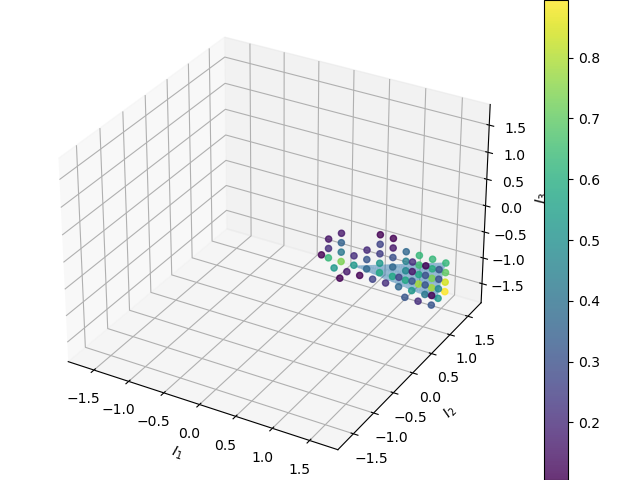

[-17.34433095   3.46655221   8.87895707   2.7058553 ]


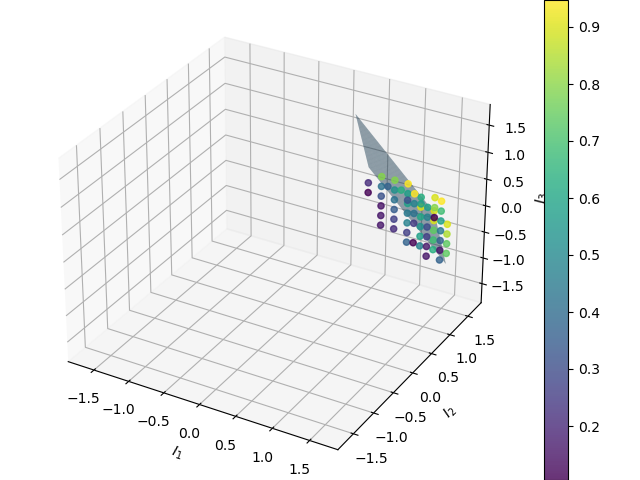


1312
0.9996302560782715
left
639
0.8464391848571365
right
673
0.9110971601305419
left
227
0.9178700501297827
left
106
0.8969259063191486
right
121
0.8454148214609702
right
446
0.8112391305409355
[-7.34915689  4.14410917  3.88446938  6.27020808]


/tmp/ipykernel_12311/3784309780.py:52: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


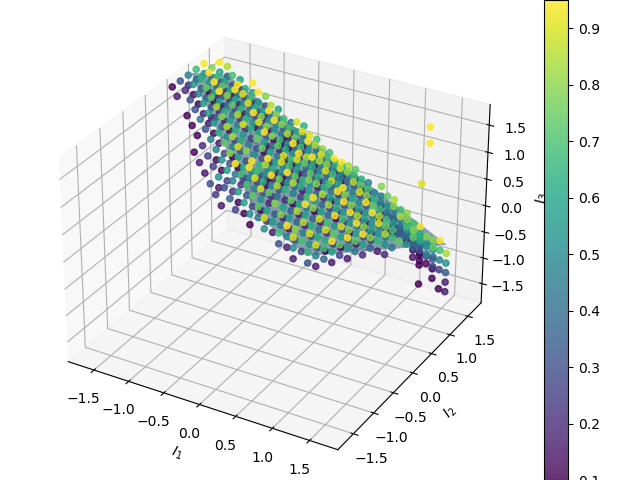

[-8.43868248 -3.49083696 -4.35167218 -3.37117421]


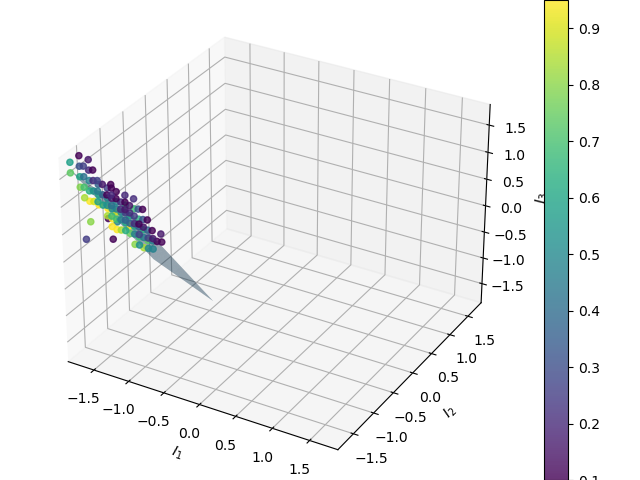

[-10.99849827  -5.69046423  -6.33480812  -9.02523028]


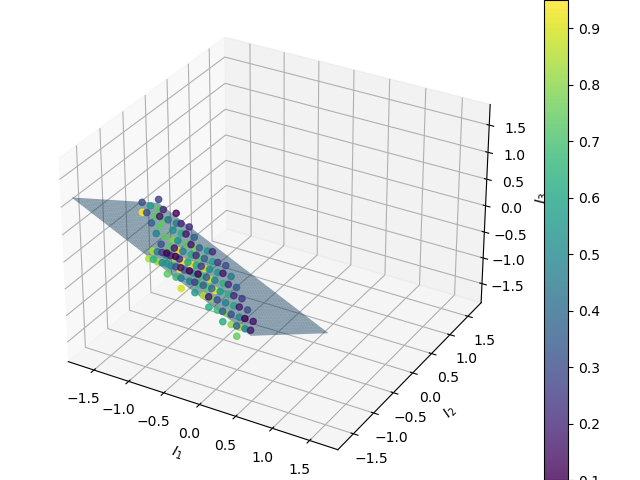

[-10.4470522   -5.21126471  -4.6646631  -10.10793456]


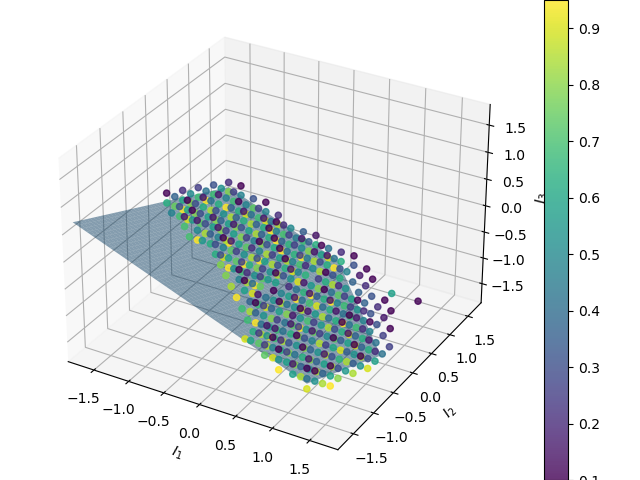

0
Optimal value 1.2735864801522356
optimal p_t 0.6190568570041263
optimal p_n 0.3969458820709143
optimal T_t -0.485546988453034
optimal T_n -0.4182069863160919
[ 1.4        -1.78124999 -0.80475113]
1
Optimal value 8.54112278599074
optimal p_t 0.1300557874803668
optimal p_n 0.6493829663382557
optimal T_t 1.9004655931838934
optimal T_n 0.6163280738545827
[-0.26242247  1.78124999 -1.78124999]
2
Optimal value 1.6885714261847014
optimal p_t 0.540684283533165
optimal p_n 0.45624491335299533
optimal T_t -0.1630977200267001
optimal T_n -0.17546918109305049
[ 1.4       -1.78125   -0.8316466]
3
Optimal value 0.25079451071033554
optimal p_t 0.8453784789855799
optimal p_n 0.06357605481251022
optimal T_t -1.6988041002460137
optimal T_n -2.689831404032298
[-1.14652703 -1.78125     1.78124997]
4
Optimal value 0.9231942908475901
optimal p_t 0.547189780845434
optimal p_n 0.08732041916052545
optimal T_t -0.18932259533983248
optimal T_n -2.3468005350627674
[ 0.18164561 -1.78125     1.78125   ]
5
Optimal 

/tmp/ipykernel_12311/4237131055.py:42: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


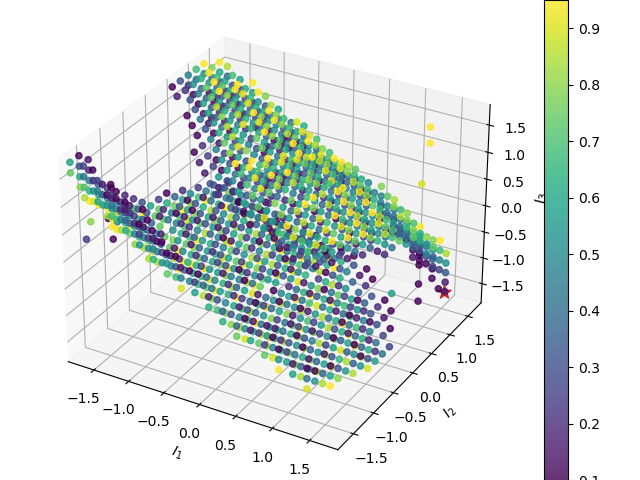

/tmp/ipykernel_12311/4237131055.py:62: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


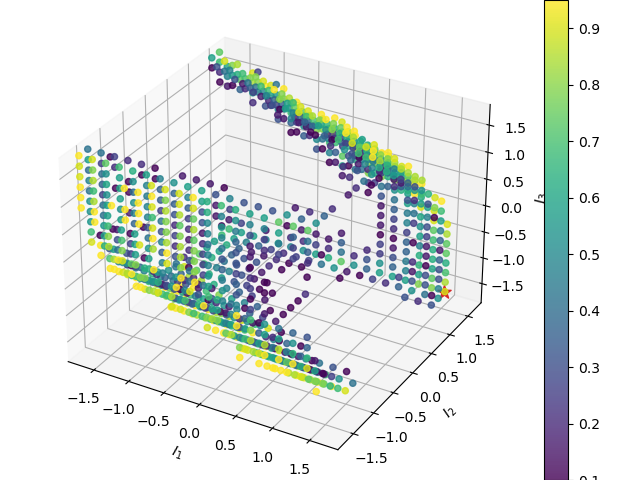

In [17]:
selec_comparison = []
for m in range(len(all_targets)):
    m = 0
    targets = all_targets[m]
    nontargets = all_nontargets[m]

    classification = classifySelectivity(targets, nontargets)
    print(targets, nontargets, classification)
    
    best_1elec = get1elecSelectivity(dataset, electrical_path, gsort_path_1elec, estim_1elec, 
                                     wnoise, p, targets, nontargets, show_plots=True)
    
    print(best_1elec)
    
    t_weights, t_amps, t_probs = fitMultielecSurface(electrical_path, gsort_path, dataset, estim, wnoise, p,
                                                     targets, downsample=False, downsample_trials=10, 
                                                     downsample_factor=2, load_from_mat=True, nll_thr=0.9, 
                                                     min_points_per_cluster=15, show_plots=True, verbose=True)
    nt_weights, nt_amps, nt_probs = fitMultielecSurface(electrical_path, gsort_path, dataset, estim, wnoise, p,
                                                        nontargets, downsample=False, downsample_trials=10, 
                                                        downsample_factor=2, load_from_mat=True, nll_thr=0.9, 
                                                        min_points_per_cluster=15, show_plots=True, verbose=True)
    
    target_combos_flat = cartesian_product_pp(t_weights)
    target_combos = np.reshape(target_combos_flat, (len(target_combos_flat), len(targets), 
                                                int(target_combos_flat.shape[-1] / len(targets))))
    
    nt_weights = np.vstack((nt_weights))
    
    selec_vals, x_vals = computeSelecVec(target_combos, nt_weights, verbose=True)
    print(selec_vals, x_vals)
    selec_vec = x_vals[np.argsort(selec_vals)[-1]]
    print(selec_vec)
    best_multielec = np.amax(selec_vals)
    print(best_multielec)
    
    selec_comparison.append((best_1elec, best_multielec, classification))
    
    for i in range(len(nt_amps)):
        fig = plt.figure()
        fig.clear()
        ax = Axes3D(fig)
        plt.xlabel(r'$I_1$')
        plt.ylabel(r'$I_2$')
        plt.xlim(-1.8, 1.8)
        plt.ylim(-1.8, 1.8)
        ax.set_zlim(-1.8, 1.8)
        ax.set_zlabel(r'$I_3$')

        scat = ax.scatter(nt_amps[i][:, 0], 
                    nt_amps[i][:, 1],
                    nt_amps[i][:, 2], marker='o', s=20, c=nt_probs[i], alpha=0.8)

        ax.scatter(selec_vec[0], selec_vec[1], selec_vec[2], c='tab:red', marker='*', s=100)

        clb = plt.colorbar(scat)
        plt.show()
        
    for i in range(len(t_amps)):
        fig = plt.figure()
        fig.clear()
        ax = Axes3D(fig)
        plt.xlabel(r'$I_1$')
        plt.ylabel(r'$I_2$')
        plt.xlim(-1.8, 1.8)
        plt.ylim(-1.8, 1.8)
        ax.set_zlim(-1.8, 1.8)
        ax.set_zlabel(r'$I_3$')

        scat = ax.scatter(t_amps[i][:, 0], 
                    t_amps[i][:, 1],
                    t_amps[i][:, 2], marker='o', s=20, c=t_probs[i], alpha=0.8)

        ax.scatter(selec_vec[0], selec_vec[1], selec_vec[2], c='tab:red', marker='*', s=100)

        clb = plt.colorbar(scat)
        plt.show()

    break

In [ ]:
# t_weights = []
# t_amps = []
# t_probs = []
# for t in targets:
#     X, y, T = mutils.loadNewLVData(electrical_path, gsort_path, dataset, estim, wnoise, p, t,
#                                    downsample=False, downsample_trials=10, downsample_factor=2,
#                                    load_from_mat=True, MATFILE_BASE=MATFILE_BASE)
#     t_amps.append(X)
#     t_probs.append(y)
#     output = binaryClustering(X, y, T, nll_thr=0.9, min_points_per_cluster=15)

#     cell_weights = []
#     for i in range(len(output)):
#         print(output[i][2])

#         if len(output[i][2]) > 1:
# #             OLS_X = sm.add_constant(output[i][0], has_constant='add')
# #             OLS_y = np.log(output[i][1] / (1 - output[i][1]))

# #             OLS_w = (np.linalg.inv(OLS_X.T @ OLS_X) @ OLS_X.T) @ OLS_y
# #             print(OLS_w)
            
#             cell_weights.append(output[i][2])
#             normal = output[i][2][1:]

#             d = output[i][2][0]
#             xmin = np.amin(output[i][0][:, 0])
#             xmax = np.amax(output[i][0][:, 0])
#             ymin = np.amin(output[i][0][:, 1])
#             ymax = np.amax(output[i][0][:, 1])

#             # create x,y
#             xx, yy = np.meshgrid(np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100))

#             # calculate corresponding z
#             z = (-d - normal[0] * xx - normal[1] * yy) / normal[2]
#             z[z > 1.8] = np.nan
#             z[z < -1.8] = np.nan

#             # plot the surface
#             fig = plt.figure()
#             fig.clear()
#             ax = Axes3D(fig)
#             ax.plot_surface(xx, yy, z, alpha=0.5)
#             plt.xlabel(r'$I_1$')
#             plt.ylabel(r'$I_2$')
#             plt.xlim(-1.8, 1.8)
#             plt.ylim(-1.8, 1.8)
#             ax.set_zlim(-1.8, 1.8)
#             ax.set_zlabel(r'$I_3$')

#             scat = ax.scatter(output[i][0][:, 0], 
#                         output[i][0][:, 1],
#                         output[i][0][:, 2], marker='o', s=20, c=output[i][1], alpha=0.8)

#             clb = plt.colorbar(scat)
#             plt.show()
            
#     t_weights.append(np.array(cell_weights))

In [ ]:
# target_combos_flat = cartesian_product_pp(t_weights)

In [ ]:
# target_combos_flat

In [ ]:
# target_combos = np.reshape(target_combos_flat, (len(target_combos_flat), len(targets), 
#                                                 int(target_combos_flat.shape[-1] / len(targets))))

In [ ]:
# nt_weights = []
# nt_amps = []
# nt_probs = []
# for nt in nontargets:
#     X, y, T = mutils.loadNewLVData(electrical_path, gsort_path, dataset, estim, wnoise, p, nt,
#                                    downsample=False, downsample_trials=10, downsample_factor=2,
#                                    load_from_mat=True, MATFILE_BASE=MATFILE_BASE)
#     nt_amps.append(X)
#     nt_probs.append(y)
#     output = binaryClustering(X, y, T, nll_thr=0.9, min_points_per_cluster=15)

#     for i in range(len(output)):
#         print(output[i][2])

#         if len(output[i][2]) > 1:
#             nt_weights.append(output[i][2])
#             normal = output[i][2][1:]

#             d = output[i][2][0]
#             xmin = np.amin(output[i][0][:, 0])
#             xmax = np.amax(output[i][0][:, 0])
#             ymin = np.amin(output[i][0][:, 1])
#             ymax = np.amax(output[i][0][:, 1])

#             # create x,y
#             xx, yy = np.meshgrid(np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100))

#             # calculate corresponding z
#             z = (-d - normal[0] * xx - normal[1] * yy) / normal[2]
#             z[z > 1.8] = np.nan
#             z[z < -1.8] = np.nan

#             # plot the surface
#             fig = plt.figure()
#             fig.clear()
#             ax = Axes3D(fig)
#             ax.plot_surface(xx, yy, z, alpha=0.5)
#             plt.xlabel(r'$I_1$')
#             plt.ylabel(r'$I_2$')
#             plt.xlim(-1.8, 1.8)
#             plt.ylim(-1.8, 1.8)
#             ax.set_zlim(-1.8, 1.8)
#             ax.set_zlabel(r'$I_3$')

#             scat = ax.scatter(output[i][0][:, 0], 
#                         output[i][0][:, 1],
#                         output[i][0][:, 2], marker='o', s=20, c=output[i][1], alpha=0.8)

#             clb = plt.colorbar(scat)
#             plt.show()

# nt_weights = np.vstack((nt_weights))

In [ ]:
# target_combos

In [ ]:
# nt_weights

In [ ]:
# I_max = 1.78125
# selec_vals = np.zeros(len(target_combos))
# x_vals = np.zeros((len(target_combos), 3))
# for i in range(len(target_combos)):
#     print(i)
#     T_t = cp.Variable(1)
#     T_n = cp.Variable(1)
#     x = cp.Variable(3)

#     constraints = [
#         -target_combos[i, :, 0] - target_combos[i, :, 1:] @ x  <= T_t,
#         nt_weights[:, 0] + nt_weights[:, 1:] @ x <= T_n,
#         x[0] <= 1.4,
#         -I_max <= x[0],
#         x[1] <= I_max,
#         -I_max <= x[1], 
#         x[2] <= I_max,
#         -I_max <= x[2],  
#     ]

#     objective_function = cp.exp(T_n) + cp.exp(T_t)

#     objective = cp.Minimize(objective_function)
#     prob = cp.Problem(objective, constraints)
#     opt_val  = prob.solve()
#     print(f"Optimal value {opt_val}")

#     print(f"optimal p_t {compute_pt(T_t.value)[0]}")
#     print(f"optimal p_n {compute_pn(T_n.value)[0]}")
#     print(f"optimal T_t {T_t.value[0]}")
#     print(f"optimal T_n {T_n.value[0]}")
#     print(x.value)

#     selec_vals[i] = compute_pt(T_t.value)[0] * (1 - compute_pn(T_n.value)[0])
#     x_vals[i] = x.value

In [ ]:
# selec_vals

In [ ]:
# selec_vals[np.argsort(selec_vals)]

In [ ]:
# x_vals[np.argsort(selec_vals)]

In [ ]:
# selec_vec = x_vals[np.argsort(selec_vals)[-1]]

In [ ]:
# for i in range(len(nt_amps)):
#     fig = plt.figure()
#     fig.clear()
#     ax = Axes3D(fig)
#     plt.xlabel(r'$I_1$')
#     plt.ylabel(r'$I_2$')
#     plt.xlim(-1.8, 1.8)
#     plt.ylim(-1.8, 1.8)
#     ax.set_zlim(-1.8, 1.8)
#     ax.set_zlabel(r'$I_3$')

#     scat = ax.scatter(nt_amps[i][:, 0], 
#                 nt_amps[i][:, 1],
#                 nt_amps[i][:, 2], marker='o', s=20, c=nt_probs[i], alpha=0.8)

#     ax.scatter(selec_vec[0], selec_vec[1], selec_vec[2], c='tab:red', marker='*', s=100)

#     clb = plt.colorbar(scat)
#     plt.show()

In [ ]:
# for i in range(len(t_amps)):
#     fig = plt.figure()
#     fig.clear()
#     ax = Axes3D(fig)
#     plt.xlabel(r'$I_1$')
#     plt.ylabel(r'$I_2$')
#     plt.xlim(-1.8, 1.8)
#     plt.ylim(-1.8, 1.8)
#     ax.set_zlim(-1.8, 1.8)
#     ax.set_zlabel(r'$I_3$')

#     scat = ax.scatter(t_amps[i][:, 0], 
#                 t_amps[i][:, 1],
#                 t_amps[i][:, 2], marker='o', s=20, c=t_probs[i], alpha=0.8)

#     ax.scatter(selec_vec[0], selec_vec[1], selec_vec[2], c='tab:red', marker='*', s=100)

#     clb = plt.colorbar(scat)
#     plt.show()

In [ ]:
plt.figure()
plt.scatter(np.array(selec_comparison)[:, 0], np.array(selec_comparison)[:, 1], alpha=0.5)
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), linestyle='--', c='k')